## 04 - sklearn TfidfVectorizer() and KMeans()

* [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [sklearn.metrics.pairwise.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html)

* [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering)
* [sklearn KMeans()](http://scikit-learn.org/stable/modules/clustering.html#k-means)
* [Document Clustering with Python](http://brandonrose.org/clustering)

This ipython notebook evaulates both CountVectorizer and TfidfVectorizer with KMeans to cluster resumes.

In [47]:
import nltk
import pandas as pd
import numpy as np
import pickle
import pymongo
import seaborn as sns
import string
import re
import os

from collections import defaultdict, Counter

## NLP
from nltk.corpus import treebank, stopwords
from nltk import bigrams, trigrams
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.neighbors import kneighbors_graph

from textblob import TextBlob

from sklearn.manifold import MDS

## Database
from pymongo import MongoClient

## Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
def pickleme(temp, filename):
    
    with open(filename + '.pkl', 'w') as picklefile:
        pickle.dump(temp, picklefile)
    
    return

In [49]:
def getpickle(filename):

    try:
        with open(filename + '.pkl', 'rb') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [50]:
def tokenizenstem(temp, stem = True, nouns = True):
    
    global stopwords
    
    temptokens = []
    
    if nouns:
        blob = TextBlob(temp)
        tokens = blob.noun_phrases
    else:
        tokens = nltk.word_tokenize(temp)
    
    ##  Creates instance of WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    for word in tokens:
        if word.lower() not in stopwords and word not in string.punctuation and len(word) > 2:# and re.search('[a-zA-Z]', word):
            if stem:
                temptokens.append(wnl.lemmatize(word.lower()))
            else:
                temptokens.append(word.lower())
    
    return temptokens

In [51]:
def getstopwords():

    STOP_WORDS = list(getpickle('stopwords'))
    stopwords = getpickle('resumestopwords')
    
    stopwords = [item for sublist in [list(STOP_WORDS) + stopwords] for item in sublist]
    
    return stopwords

In [52]:
def addtostoplist(tempword):
    
    stopwords = getpickle('resumestopwords')
    
    stopwords.append(tempword)
    
    stopwords = list(set(stopwords))
    
    pickleme(stopwords, 'resumestopwords')
    
    print tempword + ' added to State of the Union stop word list.'
    
    return

In [53]:
colors = getpickle('tableaucolors')
stopwords = getstopwords()

In [9]:
! brew services start mongodb

Service `mongodb` already started, use `brew services restart mongodb` to restart.


In [10]:
# ! brew services stop mongodb

In [54]:
## Initialize MongoDB for use
client = MongoClient()
db = client['resume_db']
resumes = db.resume_collection

In [55]:
print "Count of number of documents:", resumes.count()
print "Keys in one example document:", resumes.find_one().keys()
# resumes.find_one() # Uncomment this line to see what a full document looks like.

Count of number of documents: 73
Keys in one example document: [u'_id', u'Id', u'Resume']


In [56]:
corpus = []
tokens = []

for resume in resumes.find({}, {'Resume' : 1, "_id": 0}):
    corpus.append(resume['Resume'])
    tokens.append(tokenizenstem(resume['Resume'], stem = True, nouns = False))

print len(corpus), len(tokens)

73 73


In [57]:
nouns = False
ngrams = 3

mxdf = 0.45
mindf = 0.08

totalvocab_stemmed = []
totalvocab_tokenized = []

for tempresume in corpus:
    allwords_stemmed = tokenizenstem(tempresume, True, nouns)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenizenstem(tempresume, False, nouns)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

cv = False

if cv == True:
    vect = CountVectorizer(input = 'content', encoding = 'utf-8', decode_error = 'strict', strip_accents = None,
                           lowercase=True, preprocessor = None, tokenizer = tokenizenstem, stop_words = stopwords,
                           token_pattern='(?u)\b\w\w+\b', ngram_range = (1, ngrams), analyzer = 'word', 
                           max_df = mxdf, min_df = mindf, max_features = None, vocabulary = None, binary = False)    
else:
    vect = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, 
                           lowercase=True, preprocessor=None, tokenizer = tokenizenstem, analyzer='word', 
                           stop_words = stopwords, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, ngrams), 
                           max_df = mxdf, min_df = mindf, max_features=None, vocabulary=None, binary=False,
                           norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)


tfidfmatrix = vect.fit_transform(corpus)

In [58]:
tfidfmatrix.shape

(73, 92)

In [59]:
terms = vect.get_feature_names()

dist = 1 - cosine_similarity(tfidfmatrix)

## sklearn KMeans()

In [60]:
num_clusters = 5

km = KMeans(n_clusters = num_clusters)
km.fit(tfidfmatrix)

clusters = km.labels_.tolist()

cluster = defaultdict(int)

for i, node in enumerate(clusters):
    cluster[node] += 1

resnames = getpickle('resumenames')

# print len(clusters), len(resnames)

resumes = {'Resume' : resnames , 'cluster': clusters}

frame = pd.DataFrame({'Resume' : resnames, 
                      'Cluster': clusters})

clusterres = defaultdict(list)

for i in range(len(corpus)):
    clusterres[clusters[i]].append(resnames[i])

In [61]:
frame['Cluster'].value_counts()

4    20
2    17
1    16
3    11
0     9
Name: Cluster, dtype: int64

In [46]:
print 'Top terms per cluster:\n'

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    
    print 'Cluster %d' % i, '\n\tSample words:\t' ,
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print '%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0] + ',',

    print '\n\tResumes:\t',clusterres[i]
    
print '\n'

Top terms per cluster:

Cluster 0 
	Sample words:	
	Resumes:	['Resume 004', 'Resume 010', 'Resume 011', 'Resume 012', 'Resume 015', 'Resume 017', 'Resume 020', 'Resume 021', 'Resume 031', 'Resume 034', 'Resume 036', 'Resume 039', 'Resume 047', 'Resume 050', 'Resume 052', 'Resume 060', 'Resume 068', 'Resume 072']
Cluster 1 
	Sample words:	
	Resumes:	['Resume 003', 'Resume 005', 'Resume 007', 'Resume 013', 'Resume 014', 'Resume 016', 'Resume 026', 'Resume 056']
Cluster 2 
	Sample words:	
	Resumes:	['Resume 001', 'Resume 018', 'Resume 025', 'Resume 027', 'Resume 030', 'Resume 035', 'Resume 037', 'Resume 048', 'Resume 055', 'Resume 063', 'Resume 064', 'Resume 071', 'Resume 073']
Cluster 3 
	Sample words:	
	Resumes:	['Resume 006', 'Resume 008', 'Resume 009', 'Resume 022', 'Resume 023', 'Resume 024', 'Resume 028', 'Resume 029', 'Resume 033', 'Resume 038', 'Resume 041', 'Resume 042', 'Resume 043', 'Resume 045', 'Resume 046', 'Resume 049', 'Resume 051', 'Resume 053', 'Resume 054', 'Resume 065'

### sklearn.manifold.MDS

* [sklearn.manifold.MDS](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)

In [62]:
# dissim = 'euclidean'
dissim = 'precomputed'


mds = MDS(n_components = 2, dissimilarity = dissim, random_state=0)
pos = mds.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [63]:
#set up colors per clusters using a dict

cluster_colors = {0: colors[0], 
                  1: colors[1], 
                  2: colors[2], 
                  3: colors[3], 
                  4: colors[4],
                  5: colors[5],
                  6: colors[6],
                  7: colors[7]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3',
                 4: 'Cluster 4',
                 5: 'Cluster 5',
                 6: 'Cluster 6',
                 7: 'Cluster 7'}

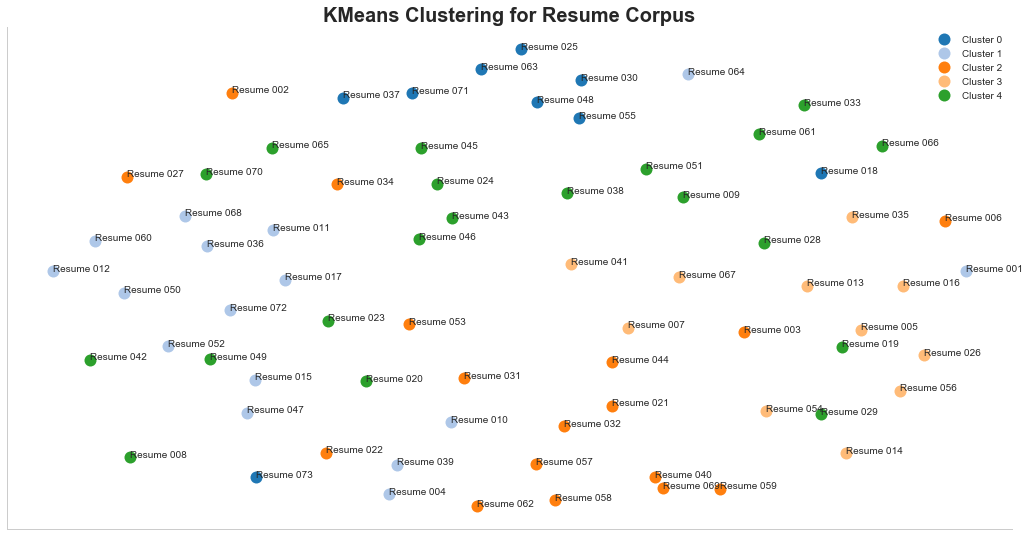

In [64]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=resnames)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(18, 9)) # set size
sns.set_style("whitegrid")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

plt.title('KMeans Clustering for Resume Corpus', fontsize = 20, fontweight = 'bold')
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=10)  

plt.grid(False)

Resume clustering is visible with KMeans, although the exact feature for the clustering is unclear.  Not all job advertisements were available at the time of the study, but it appears that clustering may be around the job advertisements for which the resumes were submitted.